## Importation des bibliothéque

In [1]:
import torch
from transformers import CLIPProcessor, CLIPModel
import matplotlib.pyplot as plt
import os
from PIL import Image
import numpy as np
import cv2

## Chargement du modèle CLIP

In [2]:
model_name = "openai/clip-vit-base-patch16"
model = CLIPModel.from_pretrained(model_name)
processor = CLIPProcessor.from_pretrained(model_name)

## Fonctions utilitaires

In [3]:
def detect_edges(pil_image):
    """
    Convertit une image PIL en niveaux de gris et applique la détection de contours (Canny).
    """
    image_np = np.array(pil_image)
    if len(image_np.shape) == 3:
        gray_image = cv2.cvtColor(image_np, cv2.COLOR_RGB2GRAY)
    else:
        gray_image = image_np
    edges = cv2.Canny(gray_image, threshold1=100, threshold2=200)
    return Image.fromarray(edges)


def extract_roi(image: Image.Image, win_size=(64, 64)):
    """
    Extrait la région d'intérêt (ROI) d'une image en détectant les contours,
    en filtrant les petits objets et en calculant une boîte englobante.
    Si aucun contour n'est détecté, l'image entière est redimensionnée.
    """
    image_np = np.array(image.convert("RGB"))
    gray = cv2.cvtColor(image_np, cv2.COLOR_RGB2GRAY)
    blurred = cv2.bilateralFilter(gray, d=9, sigmaColor=75, sigmaSpace=75)
    edges = cv2.Canny(blurred, threshold1=50, threshold2=150)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (15, 15))
    edges_dilated = cv2.dilate(edges, kernel, iterations=1)
    contours, _ = cv2.findContours(edges_dilated, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    filtered = [cnt for cnt in contours if cv2.contourArea(cnt) > 1000]
    if filtered:
        all_points = np.vstack(filtered)
        x, y, w, h = cv2.boundingRect(all_points)
        roi = image.crop((x, y, x + w, y + h))
        roi_resized = roi.resize(win_size)
        return roi_resized
    else:
        return image.resize(win_size)


def get_clip_features(pil_image: Image.Image, use_roi=False):
    """
    Extrait l'embedding CLIP de l'image.
    Si use_roi est True, on extrait d'abord la ROI (similaire à l'approche HOG).
    """
    if use_roi:
        pil_image = extract_roi(pil_image)
    inputs = processor(images=pil_image, return_tensors="pt")
    with torch.no_grad():
        features = model.get_image_features(**inputs)
    features = features / features.norm(p=2, dim=-1, keepdim=True)
    return features.squeeze()


def compute_clip_distance(image1: Image.Image, image2: Image.Image, use_roi=False):
    """
    Calcule la distance entre deux images en utilisant leurs embeddings CLIP.
    La distance est définie comme 1 - similarité cosinus.
    """
    feat1 = get_clip_features(image1, use_roi=use_roi)
    feat2 = get_clip_features(image2, use_roi=use_roi)
    cosine_sim = torch.dot(feat1, feat2).item()
    distance = 1 - cosine_sim
    return distance


def compute_clip_distance_all(query_image_path, database_path, use_roi=False):
    """
    Pour une image requête, calcule la distance avec toutes les images d'un dossier.
    Retourne une liste de tuples (nom_de_fichier, distance).
    """
    query_image = Image.open(query_image_path).convert("RGB")
    list_dist = []
    for file_name in os.listdir(database_path):
        if file_name.endswith('.jpg'):
            image_path = os.path.join(database_path, file_name)
            db_image = Image.open(image_path).convert("RGB")
            dist = compute_clip_distance(query_image, db_image, use_roi=use_roi)
            list_dist.append((file_name, dist))
    return list_dist


def display_query_results(query_image_path, database_path, use_roi=False):
    """
    Affiche les résultats pour une image requête :
      - Affichage de l'image requête.
      - Affichage du top 1 match et de ses contours.
      - Affichage en console des top 5 correspondances.
    """
    query_image = Image.open(query_image_path).convert("RGB")
    list_dist = compute_clip_distance_all(query_image_path, database_path, use_roi=use_roi)
    if not list_dist:
        print("Aucune image trouvée dans la base de données.")
        return
    top5 = sorted(list_dist, key=lambda x: x[1])[:5]
    print(f"Top 5 images pour {os.path.basename(query_image_path)} (use_roi={use_roi}) :")
    for file_name, dist in top5:
        print(f"  {file_name} : Distance = {dist:.4f}")
    top_match_path = os.path.join(database_path, top5[0][0])
    top_match_image = Image.open(top_match_path).convert("RGB")
    edges_top_match = detect_edges(top_match_image)
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 3, 1)
    plt.imshow(query_image)
    plt.title("Image Requête")
    plt.axis('off')
    plt.subplot(1, 3, 2)
    plt.imshow(top_match_image)
    plt.title("Top Match")
    plt.axis('off')
    plt.subplot(1, 3, 3)
    plt.imshow(edges_top_match, cmap='gray')
    plt.title("Contours du Top Match")
    plt.axis('off')
    plt.show()

## Application et évaluation

Top 5 images pour airplane_query.jpg (use_roi=False) :
  airplane_3.jpg : Distance = 0.1336
  airplane_2.jpg : Distance = 0.1514
  airplane_5.jpg : Distance = 0.1617
  airplane_1.jpg : Distance = 0.1893
  airplane_4.jpg : Distance = 0.2048


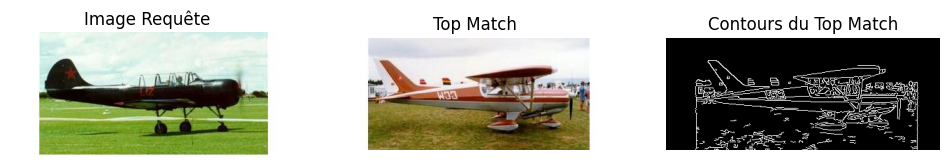

Top 5 images pour airplane_query.jpg (use_roi=True) :
  airplane_5.jpg : Distance = 0.1155
  airplane_3.jpg : Distance = 0.1235
  airplane_1.jpg : Distance = 0.1289
  airplane_2.jpg : Distance = 0.1446
  airplane_4.jpg : Distance = 0.1581


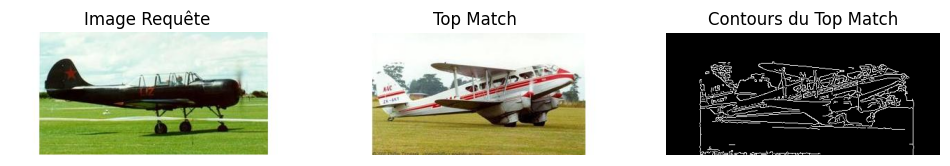

In [4]:
# Définir les chemins vers la base de données et l'image requête
database_path = "./TP1_data/database"  
query_example   = "./TP1_data/airplane_query.jpg"  

# Affichage pour une image requête sans extraction de ROI
display_query_results(query_example, database_path, use_roi=False)

# Affichage pour une image requête avec extraction de ROI
display_query_results(query_example, database_path, use_roi=True)


=== Evaluation avec ROI ===
Top 5 pour airplane (use_roi=True) : [('airplane_5.jpg', 0.1154865026473999), ('airplane_3.jpg', 0.12353652715682983), ('airplane_1.jpg', 0.12891638278961182), ('airplane_2.jpg', 0.14462602138519287), ('airplane_4.jpg', 0.15809673070907593)]
Top 5 pour ball (use_roi=True) : [('ball_2.jpg', 0.031046569347381592), ('ball_3.jpg', 0.04595828056335449), ('ball_5.jpg', 0.07401013374328613), ('ball_4.jpg', 0.1480068564414978), ('ball_1.jpg', 0.1575499176979065)]
Top 5 pour car (use_roi=True) : [('car_4.jpg', 0.0675286054611206), ('car_2.jpg', 0.06902742385864258), ('car_5.jpg', 0.08355432748794556), ('car_3.jpg', 0.08763223886489868), ('car_1.jpg', 0.09843379259109497)]
Top 5 pour cat (use_roi=True) : [('cat_5.jpg', 0.08298516273498535), ('cat_4.jpg', 0.10748469829559326), ('cat_2.jpg', 0.11167263984680176), ('cat_1.jpg', 0.11882555484771729), ('cat_3.jpg', 0.16097426414489746)]
Top 5 pour dolphin (use_roi=True) : [('dolphin_2.jpg', 0.13212597370147705), ('dolphin

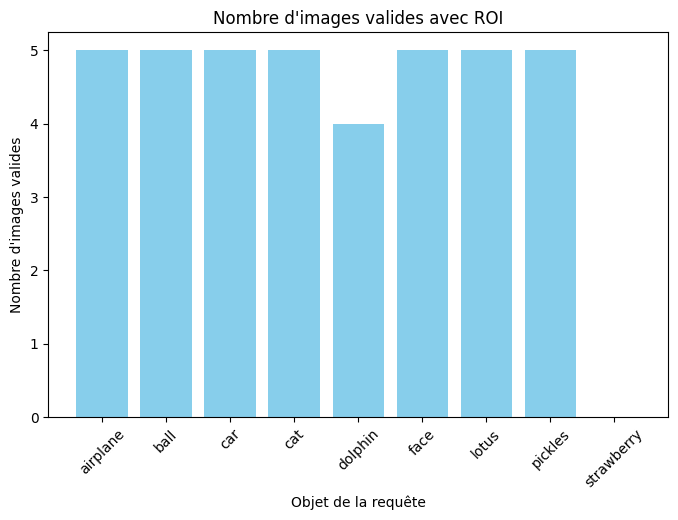


=== Evaluation sans ROI ===
Top 5 pour airplane (use_roi=False) : [('airplane_3.jpg', 0.1335991621017456), ('airplane_2.jpg', 0.1514188051223755), ('airplane_5.jpg', 0.16173213720321655), ('airplane_1.jpg', 0.18928515911102295), ('airplane_4.jpg', 0.20476502180099487)]
Top 5 pour ball (use_roi=False) : [('ball_2.jpg', 0.048135995864868164), ('ball_4.jpg', 0.0522388219833374), ('ball_3.jpg', 0.0762174129486084), ('ball_1.jpg', 0.08618354797363281), ('ball_5.jpg', 0.09898698329925537)]
Top 5 pour car (use_roi=False) : [('car_4.jpg', 0.07826453447341919), ('car_1.jpg', 0.10649001598358154), ('car_3.jpg', 0.1106717586517334), ('car_2.jpg', 0.11865198612213135), ('car_5.jpg', 0.1281207799911499)]
Top 5 pour cat (use_roi=False) : [('cat_5.jpg', 0.08830428123474121), ('cat_4.jpg', 0.11187601089477539), ('cat_1.jpg', 0.12103104591369629), ('cat_2.jpg', 0.1491684913635254), ('cat_3.jpg', 0.16706347465515137)]
Top 5 pour dolphin (use_roi=False) : [('dolphin_4.jpg', 0.16898345947265625), ('dolph

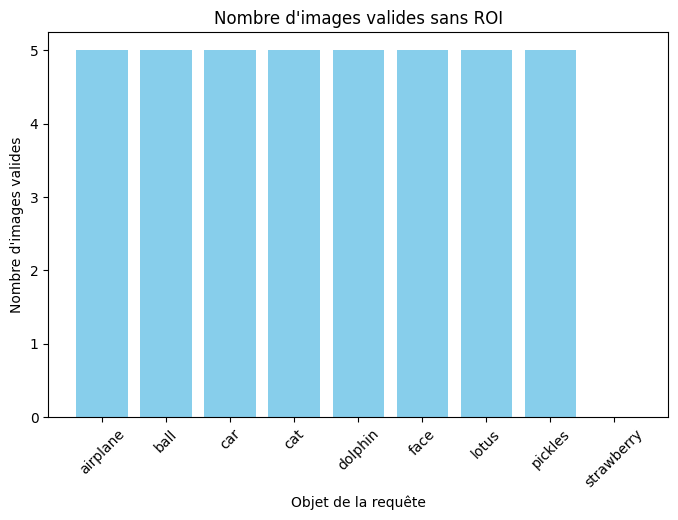

In [5]:
# Liste des catégories attendues (les noms doivent correspondre à vos fichiers, par exemple "cat_query.jpg")
categories = ["airplane", "ball", "car", "cat", "dolphin", "face", "lotus", "pickles", "strawberry"]

def evaluate_queries(categories, database_path, use_roi=False):
    """
    Pour chaque catégorie (image requête nommée '<cat>_query.jpg'),
    calcule le top 5 des correspondances et compte le nombre d'images
    valides (dont le nom contient la catégorie).
    Retourne une liste de tuples (catégorie, nombre de correspondances valides).
    """
    valid_counts = []
    for cat in categories:
        query_path = f"./TP1_data/{cat}_query.jpg"
        if not os.path.exists(query_path):
            print(f"L'image requête {query_path} n'existe pas.")
            continue
        list_dist = compute_clip_distance_all(query_path, database_path, use_roi=use_roi)
        if list_dist:
            top5 = sorted(list_dist, key=lambda x: x[1])[:5]
            count = sum(1 for file_name, _ in top5 if cat in file_name)
            valid_counts.append((cat, count))
            print(f"Top 5 pour {cat} (use_roi={use_roi}) : {top5}")
        else:
            print(f"Aucune distance calculée pour {cat}.")
    return valid_counts

# Évaluation avec extraction de ROI
print("\n=== Evaluation avec ROI ===")
valid_counts_roi = evaluate_queries(categories, database_path, use_roi=True)
if valid_counts_roi:
    labels, values = zip(*valid_counts_roi)
    plt.figure(figsize=(8, 5))
    plt.bar(labels, values, color='skyblue')
    plt.xlabel("Objet de la requête")
    plt.ylabel("Nombre d'images valides")
    plt.title("Nombre d'images valides avec ROI")
    plt.xticks(rotation=45)
    plt.show()

# Évaluation sans extraction de ROI
print("\n=== Evaluation sans ROI ===")
valid_counts = evaluate_queries(categories, database_path, use_roi=False)
if valid_counts:
    labels, values = zip(*valid_counts)
    plt.figure(figsize=(8, 5))
    plt.bar(labels, values, color='skyblue')
    plt.xlabel("Objet de la requête")
    plt.ylabel("Nombre d'images valides")
    plt.title("Nombre d'images valides sans ROI")
    plt.xticks(rotation=45)
    plt.show()